<a href="https://colab.research.google.com/github/crispyrinux/Comparing-Explainability-Methods/blob/main/GRADCAM_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values to [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0

print("Train shape:", x_train.shape)
print("Test shape:", x_test.shape)


Train shape: (50000, 32, 32, 3)
Test shape: (10000, 32, 32, 3)


In [ ]:
# Preprocess & resize layer to match ResNet input (224x224)
resize_layer = keras.layers.Resizing(224, 224)

# Base model: ResNet50 pretrained on ImageNet
base_model = keras.applications.ResNet50(
    weights="imagenet", include_top=False, input_shape=(224,224,3)
)

# Tambahkan layer classification sesuai CIFAR-10
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=base_model.input, outputs=output)

# Freeze base model (supaya cepat)
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


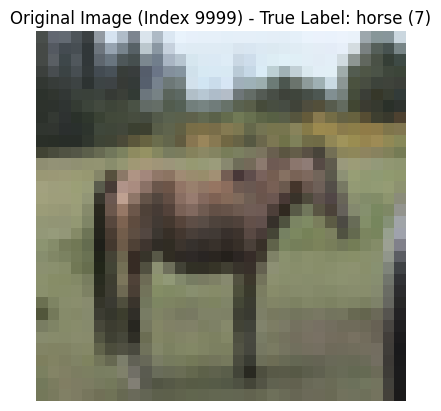

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
True Label: horse (7)
Predicted Label: ship (8)


In [ ]:
# CIFAR-10 class names
cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Ambil gambar ke-9999 dari test set
idx = 9999
img = x_test[idx]
label = y_test[idx][0]

# Tampilkan gambar asli
plt.imshow(img)
plt.title(f"Original Image (Index {idx}) - True Label: {cifar10_labels[label]} ({label})")
plt.axis("off")
plt.show()

# Resize ke 224x224 untuk input ResNet
img_resized = resize_layer(np.expand_dims(img, axis=0))

# Prediksi kelas
preds = model.predict(img_resized)
pred_class = np.argmax(preds[0])

print("True Label:", cifar10_labels[label], f"({label})")
print("Predicted Label:", cifar10_labels[pred_class], f"({pred_class})")


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Hitung gradien
    grads = tape.gradient(class_channel, conv_outputs)

    # Pool gradien
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Kalikan importance ke feature map
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalisasi 0-1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_354']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


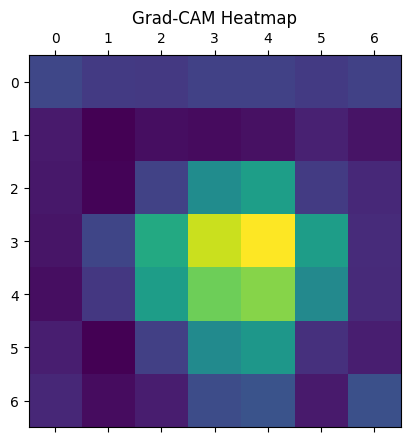

In [ ]:
# Tentukan layer terakhir conv di ResNet50
last_conv_layer_name = "conv5_block3_out"

# Buat heatmap
heatmap = make_gradcam_heatmap(img_resized, model, last_conv_layer_name)

# Plot heatmap
plt.matshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.show()


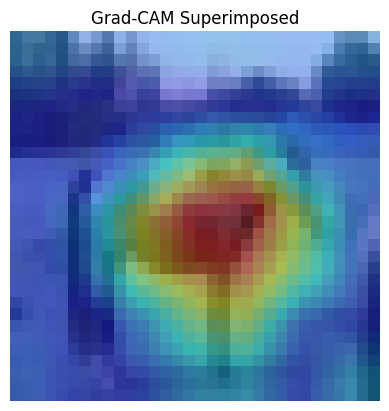

In [ ]:
import cv2

def superimpose_heatmap(img, heatmap, alpha=0.4):
    # Resize heatmap ke ukuran gambar
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose
    superimposed_img = cv2.addWeighted(heatmap, alpha, np.uint8(img*255), 1-alpha, 0)
    return superimposed_img

superimposed_img = superimpose_heatmap(img, heatmap)

# Tampilkan hasil
plt.imshow(superimposed_img[..., ::-1])  # convert BGR->RGB
plt.title("Grad-CAM Superimposed")
plt.axis("off")
plt.show()
